In [2]:
import SimpleITK as sitk
from platipy.imaging import ImageVisualiser
from platipy.imaging.registration.linear import linear_registration, alignment_registration
from platipy.imaging.registration.utils import apply_transform
from pathlib import Path
import glob
import numpy as np

In [3]:
img_ct_lung_5 = sitk.ReadImage("./PRHGD5257_LUNG/IMAGES/PRHGD5257_LUNG_0_CT_NON_CONTRAST_CHEST_5.nii.gz")
img_ct_lung_10 = sitk.ReadImage("./PRHGD5257_LUNG/IMAGES/PRHGD5257_LUNG_1_CT_NON_CONTRAST_CHEST_10.nii.gz")

In [4]:
def point2str(point, precision=1):
    """
    Format a point for printing, based on specified precision with trailing zeros. Uniform printing for vector-like data 
    (tuple, numpy array, list).
    
    Args:
        point (vector-like): nD point with floating point coordinates.
        precision (int): Number of digits after the decimal point.
    Return:
        String represntation of the given point "xx.xxx yy.yyy zz.zzz...".
    """
    return ' '.join(f'{c:.{precision}f}' for c in point)


def uniform_random_points(bounds, num_points):
    """
    Generate random (uniform withing bounds) nD point cloud. Dimension is based on the number of pairs in the bounds input.
    
    Args:
        bounds (list(tuple-like)): list where each tuple defines the coordinate bounds.
        num_points (int): number of points to generate.
    
    Returns:
        list containing num_points numpy arrays whose coordinates are within the given bounds.
    """
    internal_bounds = [sorted(b) for b in bounds]
         # Generate rows for each of the coordinates according to the given bounds, stack into an array, 
         # and split into a list of points.
    mat = np.vstack([np.random.uniform(b[0], b[1], num_points) for b in internal_bounds])
    return list(mat[:len(bounds)].T)


def target_registration_errors(tx, point_list, reference_point_list):
    """
    Distances between points transformed by the given transformation and their
    location in another coordinate system. When the points are only used to evaluate
    registration accuracy (not used in the registration) this is the target registration
    error (TRE).
    """
    return [np.linalg.norm(np.array(tx.TransformPoint(p)) -  np.array(p_ref))
          for p,p_ref in zip(point_list, reference_point_list)]


def print_transformation_differences(tx1, tx2):
    """
    Check whether two transformations are "equivalent" in an arbitrary spatial region 
    either 3D or 2D, [x=(-10,10), y=(-100,100), z=(-1000,1000)]. This is just a sanity check, 
    as we are just looking at the effect of the transformations on a random set of points in
    the region.
    """
    if tx1.GetDimension()==2 and tx2.GetDimension()==2:
        bounds = [(-10,10),(-100,100)]
    elif tx1.GetDimension()==3 and tx2.GetDimension()==3:
        bounds = [(-10,10),(-100,100), (-1000,1000)]
    else:
        raise ValueError('Transformation dimensions mismatch, or unsupported transformation dimensionality')
    num_points = 10
    point_list = uniform_random_points(bounds, num_points)
    tx1_point_list = [ tx1.TransformPoint(p) for p in point_list]
    differences = target_registration_errors(tx2, point_list, tx1_point_list)
    print(tx1.GetName()+ '-' +
          tx2.GetName()+
          f':\tminDifference: {min(differences):.2f} maxDifference: {max(differences):.2f}')

In [5]:
composite_transform = sitk.ReadTransform('TransformObject.tfm')
composite_transform = sitk.CompositeTransform(composite_transform)

In [6]:
# Retrieve the 1st Transform
transform_type = composite_transform.GetNthTransform(0)

# Downcast from Composite Transform to Euler3D Transform
euler3d_transform = transform_type.Downcast()

# Retrieve the 2nd Transform
transform_type = composite_transform.GetNthTransform(1)

# Downcast from Composite Transform to VersorRigid3D Transform
versor_transform = transform_type.Downcast()

In [8]:
# Create a Data Structure to store the Matrices

class TransformObject():
    def __init__(self, _transform_type, _matrix, _center, _translation):
        self.transform_type = _transform_type
        self.matrix = _matrix
        self.center = _center
        self.translation = _translation

# Attempt to store the matrices into a class
print('Storing the Transform Attributes to Object')
transObj = TransformObject(euler3d_transform.GetName(),
                            euler3d_transform.GetMatrix(),
                            euler3d_transform.GetCenter(),
                            euler3d_transform.GetTranslation())

Storing the Transform Attributes to Object


In [9]:
new_euler = sitk.Euler3DTransform()
new_euler.SetMatrix(transObj.matrix)
new_euler.SetCenter(transObj.center)
new_euler.SetTranslation(transObj.translation)

In [10]:
# Attempt to store the matrices into a class
print('Storing the Transform Attributes to Object')
transObj = TransformObject(versor_transform.GetName(),
                            versor_transform.GetMatrix(),
                            versor_transform.GetCenter(),
                            versor_transform.GetTranslation())

Storing the Transform Attributes to Object


In [11]:
# Attempt to create a transform from thversorrices
new_versor = sitk.VersorRigid3DTransform()
new_versor.SetMatrix(transObj.matrix)
new_versor.SetCenter(transObj.center)
new_versor.SetTranslation(transObj.translation)

In [12]:
A0 = np.asarray(euler3d_transform.GetMatrix()).reshape(3,3)
c0 = np.asarray(euler3d_transform.GetCenter())
t0 = np.asarray(euler3d_transform.GetTranslation())

A1 = np.asarray(new_versor.GetMatrix()).reshape(3,3)
c1 = np.asarray(new_versor.GetCenter())
t1 = np.asarray(new_versor.GetTranslation())

combined_mat = np.dot(A0,A1)
combined_center = c1
combined_translation = np.dot(A0, t1+c1-c0) + t0+c0-c1
combined_affine = sitk.AffineTransform(combined_mat.flatten(), 
                                        combined_translation, 
                                        combined_center)

In [13]:
print('Apply the two transformations to the same point cloud:')
print('\t', end='')
print_transformation_differences(composite_transform, combined_affine)

print('Transform parameters:')
print('\tComposite transform: ' + point2str(composite_transform.GetParameters(),2))
print('\tCombined affine: ' + point2str(combined_affine.GetParameters(),2))

print('Fixed parameters:')
print('\tComposite transform: ' + point2str(composite_transform.GetFixedParameters(),2))
print('\tCombined affine: ' + point2str(combined_affine.GetFixedParameters(),2))

print('combined_affine')
print(combined_affine)

Apply the two transformations to the same point cloud:
	CompositeTransform-AffineTransform:	minDifference: 0.00 maxDifference: 0.00
Transform parameters:
	Composite transform: -0.01 -0.03 0.01 -1.47 15.05 8.99
	Combined affine: 1.00 -0.02 -0.05 0.02 1.00 0.02 0.05 -0.02 1.00 -7.72 15.05 -43.51
Fixed parameters:
	Composite transform: 6.26 0.01 1733.50
	Combined affine: 6.26 0.01 1733.50
combined_affine
itk::simple::AffineTransform
 AffineTransform (0000022E3AF1DFA0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 1
   Modified Time: 1152
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.99841 -0.0163883 -0.0539281 
     0.017555 0.99962 0.0212323 
     0.0535596 -0.0221453 0.998319 
   Offset: [85.7739, -21.8618, -40.9268]
   Center: [6.25701, 0.00700536, 1733.5]
   Translation: [-7.72047, 15.0542, -43.5058]
   Inverse: 
     0.99841 0.017555 0.0535596 
     -0.0163883 0.99962 -0.0221453 
     -0.0539281 0.0212323 0.998319 
   Singul

In [14]:
A = np.array(combined_affine.GetMatrix()).reshape(3,3)
c = np.array(combined_affine.GetCenter())
t = np.array(combined_affine.GetTranslation())
overall = np.eye(4)
overall[0:3,0:3] = A
overall[0:3,3] = -np.dot(A,c)+t+c

# pnt = [10,3,4]

# print(combined_affine.TransformPoint(pnt))
# print(np.dot(overall,pnt+[1]))

print(overall)

[[ 9.98410330e-01 -1.63883303e-02 -5.39280565e-02  8.57738762e+01]
 [ 1.75550328e-02  9.99620433e-01  2.12322936e-02 -2.18618027e+01]
 [ 5.35596254e-02 -2.21452500e-02  9.98319064e-01 -4.09268419e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [15]:
transformed_image = apply_transform(img_ct_lung_10, img_ct_lung_5, combined_affine)


In [16]:
print(type(overall))

<class 'numpy.ndarray'>


In [17]:
print(type(overall[1,1]))

<class 'numpy.float64'>


In [18]:
string_aray = np.array2string(overall)
print(string_aray)
print(type(string_aray))

[[ 9.98410330e-01 -1.63883303e-02 -5.39280565e-02  8.57738762e+01]
 [ 1.75550328e-02  9.99620433e-01  2.12322936e-02 -2.18618027e+01]
 [ 5.35596254e-02 -2.21452500e-02  9.98319064e-01 -4.09268419e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<class 'str'>


In [19]:
out_arr = np.array_str(overall)
print(out_arr)
print(type(out_arr))

[[ 9.98410330e-01 -1.63883303e-02 -5.39280565e-02  8.57738762e+01]
 [ 1.75550328e-02  9.99620433e-01  2.12322936e-02 -2.18618027e+01]
 [ 5.35596254e-02 -2.21452500e-02  9.98319064e-01 -4.09268419e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<class 'str'>


In [20]:
x = []
for item in overall:
    for nested_item in item:
        x.append(str(nested_item))

print(x)
print(type(x))

['0.9984103301511531', '-0.016388330267517882', '-0.053928056505942436', '85.77387615541667', '0.01755503283476227', '0.9996204332308802', '0.021232293551987837', '-21.861802651317998', '0.0535596253687027', '-0.022145250017783114', '0.998319064443835', '-40.92684185388521', '0.0', '0.0', '0.0', '1.0']
<class 'list'>


[-250, 500]
Nda_Colormix
<class 'numpy.ndarray'>
(512, 512, 3)


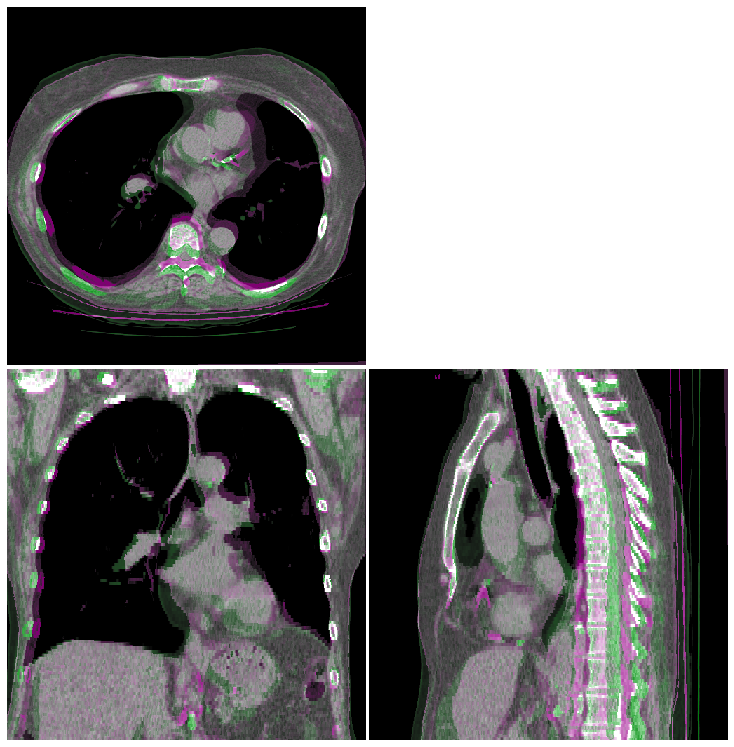

In [21]:
vis = ImageVisualiser(img_ct_lung_5)
vis.add_comparison_overlay(transformed_image)
fig = vis.show()

See if it's possible to convert the 4x4 matrix into a AffineTransform object

In [22]:
new_affine_transform = sitk.AffineTransform()

TypeError: Wrong number or type of arguments for overloaded function 'new_AffineTransform'.
  Possible C/C++ prototypes are:
    itk::simple::AffineTransform::AffineTransform(unsigned int)
    itk::simple::AffineTransform::AffineTransform(itk::simple::AffineTransform const &)
    itk::simple::AffineTransform::AffineTransform(itk::simple::Transform const &)
    itk::simple::AffineTransform::AffineTransform(std::vector< double,std::allocator< double > > const &,std::vector< double,std::allocator< double > > const &,std::vector< double,std::allocator< double > > const &)
